In [9]:
import numpy as np
import scipy.linalg as la
import scipy.spatial as spat
import math
import matplotlib.pyplot as plt
from braket.circuits import Circuit, circuit
from braket.devices import LocalSimulator
from braket.aws import AwsDevice

%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [10]:
@circuit.subroutine(register=True)
def inverse_qft(qubits):
    qftcirc = Circuit()
    num_qubits = len(qubits)

    for i in range(math.floor(num_qubits / 2)):
        qftcirc.swap(qubits[i], qubits[-i - 1])

    for k in reversed(range(num_qubits)):
        for j in reversed(range(1, num_qubits - k)):
            angle = -2 * math.pi / (2 ** (j + 1))
            qftcirc.cphaseshift(qubits[k + j], qubits[k], angle)
        qftcirc.h(qubits[k])
    return qftcirc

In [11]:
# general imports
import math
import pickle
from collections import Counter
from datetime import datetime
from braket.devices import LocalSimulator
import numpy as np
from braket.circuits import Circuit, circuit
# from utils_qft import inverse_qft

@circuit.subroutine(register=True)
def controlled_unitary(control, target_qubits, unitary):
    # Define projectors onto the computational basis
    p0 = np.array([[1.0, 0.0], [0.0, 0.0]])
    p1 = np.array([[0.0, 0.0], [0.0, 1.0]])
    circ = Circuit()

    # Construct numpy matrix
    id_matrix = np.eye(len(unitary))
    controlled_matrix = np.kron(p0, id_matrix) + np.kron(p1, unitary)
    targets = [control] + target_qubits
    
    circ.unitary(matrix=controlled_matrix, targets=targets)

    return circ


@circuit.subroutine(register=True)
def qpe(precision_qubits, query_qubits, unitary, control_unitary=True):
    qpe_circ = Circuit()
    num_precision_qubits = len(precision_qubits)
    num_query_qubits = len(query_qubits)
    qpe_circ.h(precision_qubits)
    for ii, qubit in enumerate(reversed(precision_qubits)):
        power = ii
        if control_unitary:
            Uexp = np.linalg.matrix_power(unitary, 2 ** power)
            qpe_circ.controlled_unitary(qubit, query_qubits, Uexp)
        else:
            for _ in range(2 ** power):
                qpe_circ.controlled_unitary(qubit, query_qubits, unitary)
    qpe_circ.inverse_qft(precision_qubits)

    return qpe_circ


def substring(key, precision_qubits):
    short_key = ""
    for idx in precision_qubits:
        short_key = short_key + key[idx]

    return short_key

def binaryToDecimal(binary):
    length = len(binary)
    fracDecimal = 0
    twos = 2

    for ii in range(length):
        fracDecimal += (ord(binary[ii]) - ord("0")) / twos
        twos *= 2.0
    return fracDecimal


def get_qpe_phases(measurement_counts, precision_qubits, items_to_keep=1):
    bitstrings_precision_register = [
        substring(key, precision_qubits) for key in measurement_counts.keys()
    ]
    bitstrings_precision_register_set = set(bitstrings_precision_register)
    bitstrings_precision_register_list = list(bitstrings_precision_register_set)
    precision_results_dic = {key: 0 for key in bitstrings_precision_register_list}

    for key in measurement_counts.keys():
        counts = measurement_counts[key]
        count_key = substring(key, precision_qubits)
        precision_results_dic[count_key] += counts

    c = Counter(precision_results_dic)
    topmost = c.most_common(items_to_keep)
    phases_decimal = [binaryToDecimal(item[0]) for item in topmost]

    return phases_decimal, precision_results_dic


def run_qpe(
    unitary,
    precision_qubits,
    query_qubits,
    query_circuit,
    items_to_keep=1,
    shots=1000
):
    circ = query_circuit
    circ.qpe(precision_qubits, query_qubits, unitary, control_unitary=False)

    # Add desired results_types
    
    number_precision_qubits = len(precision_qubits)
    
    num_qubits = len(precision_qubits)
    circ.probability(np.array(precision_qubits))
    device = LocalSimulator()
    task=device.run(circ,shots=2000)
    result=task.result()
    metadata = result.task_metadata

    probs_values = result.values[0]
    measurements = result.measurements
    measured_qubits = result.measured_qubits
    measurement_counts = result.measurement_counts
    measurement_probabilities = result.measurement_probabilities
    format_bitstring = "{0:0" + str(num_qubits) + "b}"
    bitstring_keys = [format_bitstring.format(ii) for ii in range(2 ** num_qubits)]


    phases_decimal, precision_results_dic = get_qpe_phases(
        measurement_counts, precision_qubits, items_to_keep
    )
    
    print('\nPhases:',phases_decimal)
    
    eigenvalues = [np.exp(2 * np.pi * 1j * phase) for phase in phases_decimal]

    # aggregate results
    out = {
        "circuit": circ,
        "task_metadata": metadata,
        "measurements": measurements,
        "measured_qubits": measured_qubits,
        "measurement_counts": measurement_counts,
        "measurement_probabilities": measurement_probabilities,
        "probs_values": probs_values,
        "bitstring_keys": bitstring_keys,
        "precision_results_dic": precision_results_dic,
        "phases_decimal": phases_decimal,
        "eigenvalues": eigenvalues,
    }

    return out


In [12]:
def postprocess_qpe_results(out,printcir=True):
    """
    Function to postprocess dictionary returned by run_qpe

    Args:
        out: dictionary containing results/information associated with QPE run as produced by run_qpe
    """
    
    # unpack results
    circ = out['circuit']
    measurement_counts = out['measurement_counts']
    bitstring_keys = out['bitstring_keys']
    probs_values = out['probs_values']
    precision_results_dic = out['precision_results_dic']
    phases_decimal = out['phases_decimal']
    eigenvalues = out['eigenvalues']
    
    # print the circuit 
    if printcir:
        print('Printing circuit:')
        print(circ)
    
    # print measurement results
    print('\nMeasurement counts:', measurement_counts)
    
    # plot probabalities
    plt.bar(bitstring_keys, probs_values);
    plt.xlabel('bitstrings');
    plt.ylabel('probability');
    plt.xticks(rotation=90);

    return eigenvalues

In [13]:
def fidelity_check(qeigvals,aeigvals,runit):
    qeigvals.sort()
    aeigvals.sort()
    qmat=np.matrix(qeigvals).round(runit)
    amat=np.matrix(aeigvals).round(runit)
    
    print('\n\nResults:')
    print('Actual Eigen Values: ',amat)
    print('Quantum Eigen Values:',qmat)
    
    qmat=np.real(qmat)
    amat=np.real(amat)
    
    cosine_similarity = 1 - spat.distance.cosine(qmat, amat)
    
    print('Fidelity:',round(cosine_similarity,runit))
    

In [14]:
def estimate_phase(n,unitary,runit,printcir=True):
    print('Unitary: \n',np.matrix(unitary).round(runit))
    eig_values, eig_vectors = np.linalg.eig(unitary)
    elen=len(eig_values)
    
    number_precision_qubits = n

    precision_qubits = range(number_precision_qubits)
    
    if elen==2:
        query_qubits = [number_precision_qubits]
    else:
        query_qubits = [number_precision_qubits, number_precision_qubits+1]

    query = Circuit().h(query_qubits)

    result = run_qpe(unitary, precision_qubits, query_qubits, query, items_to_keep=elen)
    qeigvals= postprocess_qpe_results(result,printcir)
    
    fidelity_check(qeigvals,eig_values,runit)

### Find eigen values of the 2*2 unitary matrix using QPE

Unitary: 
 [[-0.50775+0.67697j  0.53097-0.04448j]
 [ 0.15522-0.50972j  0.76865-0.35392j]]

Phases: [0.92578125, 0.359375]

Measurement counts: Counter({'111011011': 1218, '010111000': 450, '111011010': 102, '111011001': 53, '010111001': 52, '010110110': 26, '111011101': 19, '010111010': 16, '111010111': 7, '010110100': 5, '111010101': 5, '010110111': 4, '111100001': 4, '111011111': 3, '010110010': 3, '111011000': 3, '111011100': 3, '010111100': 3, '011000100': 2, '010111110': 2, '111010001': 1, '011000110': 1, '010001100': 1, '010101110': 1, '010111101': 1, '000110001': 1, '111001001': 1, '010100000': 1, '111101101': 1, '110101001': 1, '111100111': 1, '111101011': 1, '010101100': 1, '010110000': 1, '011010011': 1, '111001101': 1, '010101000': 1, '111100101': 1, '110111011': 1, '011000000': 1})


Results:
Actual Eigen Values:  [[-0.63055+0.77615j  0.89146-0.4531j ]]
Quantum Eigen Values: [[-0.63439+0.77301j  0.89322-0.44961j]]
Fidelity: 1.0


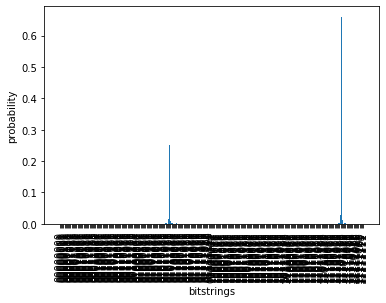

In [15]:
from scipy.stats import unitary_group
import numpy as np
np.random.seed(seed=233423)

unitary = unitary_group.rvs(2)
estimate_phase(8,unitary,5,printcir=False)

### Find eigen values of the 4*4 unitary matrix using QPE

Unitary: 
 [[-0.2984 +0.29513j  0.14789+0.73872j  0.03422+0.34418j  0.24666-0.27534j]
 [ 0.39785-0.5094j  -0.15454+0.01057j -0.04585+0.39504j -0.09168-0.62584j]
 [-0.27617+0.17326j -0.17355-0.52473j  0.49618+0.48449j  0.322  -0.06029j]
 [-0.5221 +0.16495j  0.02149-0.32016j -0.42491-0.24645j -0.13015-0.58225j]]

Phases: [0.71875, 0.234375, 0.5, 0.03125]

Measurement counts: Counter({'10111011': 548, '00111110': 283, '00111100': 209, '10111001': 134, '10000000': 117, '10000001': 107, '00111111': 96, '10111111': 78, '00001010': 72, '00111101': 66, '00001001': 43, '10111010': 40, '10111000': 31, '10110111': 29, '00001000': 22, '10000011': 18, '10111101': 14, '10110011': 11, '11000011': 9, '10110101': 8, '10100111': 6, '10111100': 5, '00001011': 5, '10000010': 4, '11000111': 3, '10111110': 3, '10101111': 3, '10110001': 2, '10100001': 2, '11001111': 2, '11000001': 2, '10000101': 1, '01001110': 1, '00100100': 1, '01010010': 1, '01000001': 1, '11001011': 1, '11000000': 1, '00101111': 1, '10010

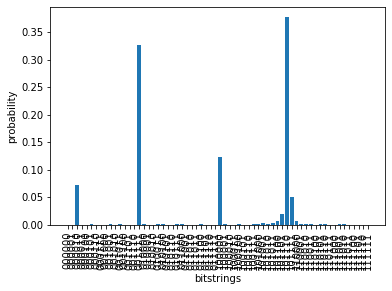

In [16]:
from scipy.stats import unitary_group
import numpy as np
np.random.seed(seed=233423)

unitary = unitary_group.rvs(4)
estimate_phase(6,unitary,5,printcir=False)